In [ ]:
from collections.abc import Callable

import numpy as np

from guppylang import guppy
from guppylang.std.builtins import (
    array, 
    comptime, 
    result, 
    owned
)
from guppylang.std.angles import pi
from guppylang.std.quantum import (
    qubit, 
    x, 
    h, 
    cx, 
    rz, 
    measure, 
    measure_array, 
    toffoli,
)

n = guppy.nat_var("n")

@guppy
def mark(
    x_array: array[int, n],
    q_array: array[qubit, n]
) -> None:
    for i in range(n):
        if not x_array[i]:
            x(q_array[i])


@guppy
def c3x(q: array[qubit, n], target: qubit) -> None:
    rz(q[0], pi * 0.125)
    rz(q[1], pi * 0.125)
    rz(q[2], pi * 0.125)
    h(target)
    cx(q[0],q[1])
    rz(target, pi * 0.125)
    rz(q[1], pi * 3.875)
    cx(q[0],q[1])
    cx(q[1],q[2])
    rz(q[2], pi * 3.875)
    cx(q[0],q[2])
    rz(q[2], pi * 0.125)
    cx(q[1],q[2])
    rz(q[2], pi * 3.875)
    cx(q[0],q[2])
    cx(q[2],target)
    rz(target, pi * 3.875)
    cx(q[1],target)
    rz(target, pi * 0.125)
    cx(q[2],target)
    rz(target, pi * 3.875)
    cx(q[0],target)
    rz(target, pi * 0.125)
    cx(q[2],target)
    rz(target, pi * 3.875)
    cx(q[1],target)
    rz(target, pi * 0.125)
    cx(q[2],target)
    rz(target, pi * 3.875)
    cx(q[0],target)
    h(target)


@guppy
def oracle(
    x_array: array[int, n],
    q_array: array[qubit, n]
) -> bool:
    ancilla = qubit()
    x(ancilla)
    h(ancilla)
    mark(x_array, q_array)
    c3x(q_array, ancilla)
    mark(x_array, q_array)
    h(ancilla)
    x(ancilla)
    b = measure(ancilla)
    return b


@guppy
def operator(
    q_array: array[qubit, n]
) -> None:
    for i in range(n):
        h(q_array[i])
        x(q_array[i])
    
    h(q_array[2])
    toffoli(q_array[0], q_array[1], q_array[2])
    h(q_array[2])

    for i in range(n):
        x(q_array[i])
        h(q_array[i])


@guppy
def grover_search(
    x_array: array[int, n],
    q_array: array[qubit, n] @owned,
    phase_oracle: Callable[
        [array[int, n],
        array[qubit, n]],
        bool
    ],
    n_iterations: int
) -> array[bool, n]:
    for _ in range(n_iterations):
        ancilla_result = phase_oracle(x_array, q_array)
        operator(q_array)
    return measure_array(q_array)


def approximate(
    N: int
) -> int:
    return np.ceil(0.25 * np.pi / np.arcsin(1/np.sqrt(2**N)) - 0.5)


mark.check()
c3x.check()
oracle.check()
operator.check()
grover_search.compile();

In [2]:
marked_state = [1, 1, 1]
N = len(marked_state)
K = int(approximate(N))
print(f"Marked State: {''.join(map(str, marked_state))}")
print(f"N: {N}")
print(f"K: {K}")

@guppy
def main() -> None:
    q_array = array(qubit() for _ in range(comptime(N)))
    for i in range(comptime(N)):
        h(q_array[i])
    x_array = array(i for i in comptime(marked_state))
    data_result = grover_search(x_array, q_array, oracle, comptime(K))
    result("data", data_result)

hugr_program = main.compile()

Marked State: 111
N: 3
K: 2


In [3]:
import qnexus as qnx

project = qnx.projects.get_or_create(
    name="grover_search",
    description="Grovers Algorithm",
)
qnx.context.set_active_project(project)

In [4]:
properties = qnx.projects.get_properties().df().name.to_list()

if "state" not in properties:
    qnx.projects.add_property(
        name="state",
        description = "marked state",
        property_type="string"
    )

if "N" not in properties:
    qnx.projects.add_property(
        name="N",
        description = "Number of qubits",
        property_type="int"
    )

if "K" not in properties:
    qnx.projects.add_property(
        name="K",
        description = "Number of grover iterations",
        property_type="int"
    )

if "oracle" not in properties:
    qnx.projects.add_property(
        name="oracle",
        description = "Grover Oracle used",
        property_type="string"
    )

In [5]:
properties = {
    "state": "111",
    "N": N,
    "K": K,
    "oracle": "Boolean"
}

In [6]:
hugr_ref = qnx.hugr.upload(
    hugr_package=hugr_program,
    properties=properties,
    name="grovers_search"
)

In [7]:
from quantinuum_schemas.models.emulator_config import StatevectorSimulator, SimpleRuntime

selene_config = qnx.SeleneConfig(
    n_qubits=N+1, 
    simulator=StatevectorSimulator(seed=0),
    runtime=SimpleRuntime(seed=0),
)

In [8]:
execute_ref =qnx.start_execute_job(
    name="execute-grover",
    programs=[hugr_ref],
    backend_config=selene_config,
    properties=properties,
    n_shots=[1000]
)

In [9]:
qnx.jobs.wait_for(execute_ref)
job_result = qnx.jobs.results(execute_ref)[0].download_result()

In [10]:
job_result.register_counts().get("data")

Counter({'111': 949,
         '011': 9,
         '100': 9,
         '010': 8,
         '000': 7,
         '001': 7,
         '110': 7,
         '101': 4})

In [11]:
distribution = {k: v/1000 for k, v in job_result.register_counts().get("data").items()}

Text(0, 0.5, 'Probability')

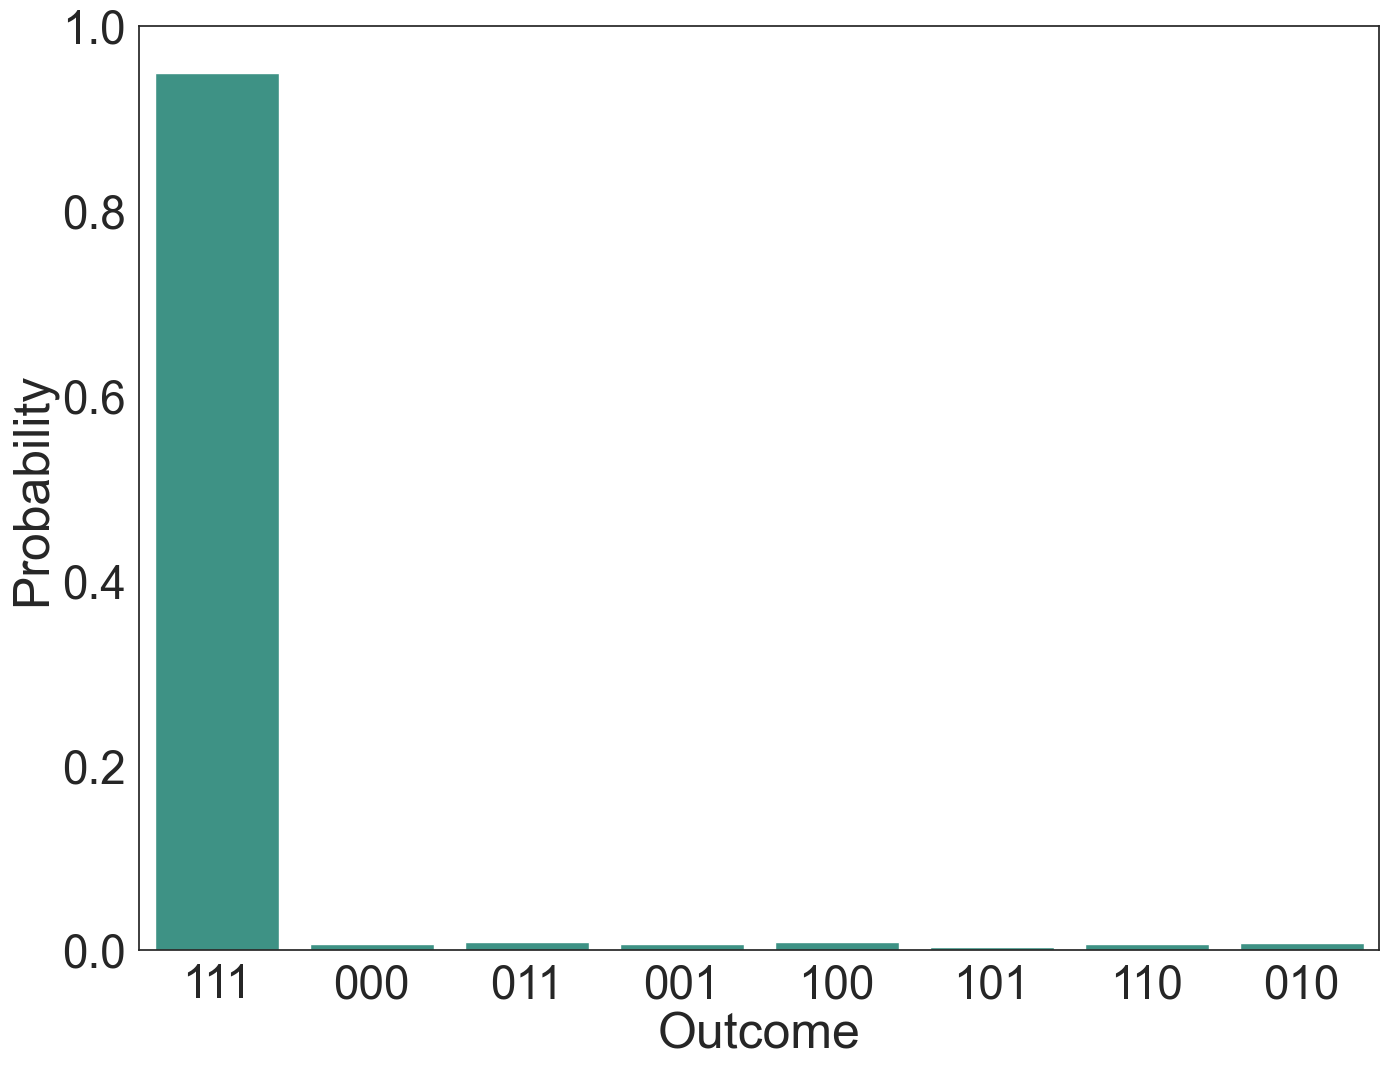

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="white", font_scale=3.0)
plt.figure(figsize=(16, 12))
ax = sns.barplot(x=distribution.keys(), y=distribution.values(), color="#30A08E")
ax.set_ylim(0, 1)
ax.set_xlabel("Outcome")
ax.set_ylabel("Probability")